In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import random
import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Root Mean Square Error 
from sklearn.metrics import mean_squared_error
from math import sqrt

# for ignore warnings
import warnings
warnings.filterwarnings("ignore")

plot_data_list = []
plot_RSME_list = []

In [2]:
df = pd.read_csv('Dataset\Pima diabetes_csv.csv')
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [5]:
round(df.describe(),2)

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00


In [6]:
# check null 
df.isnull().sum()

preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64

In [7]:
# list of numerical variables
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

numerical_variables_df = df[numerical_features]

# visualise the numerical variables
df[numerical_features].head()

Number of numerical variables:  8


,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


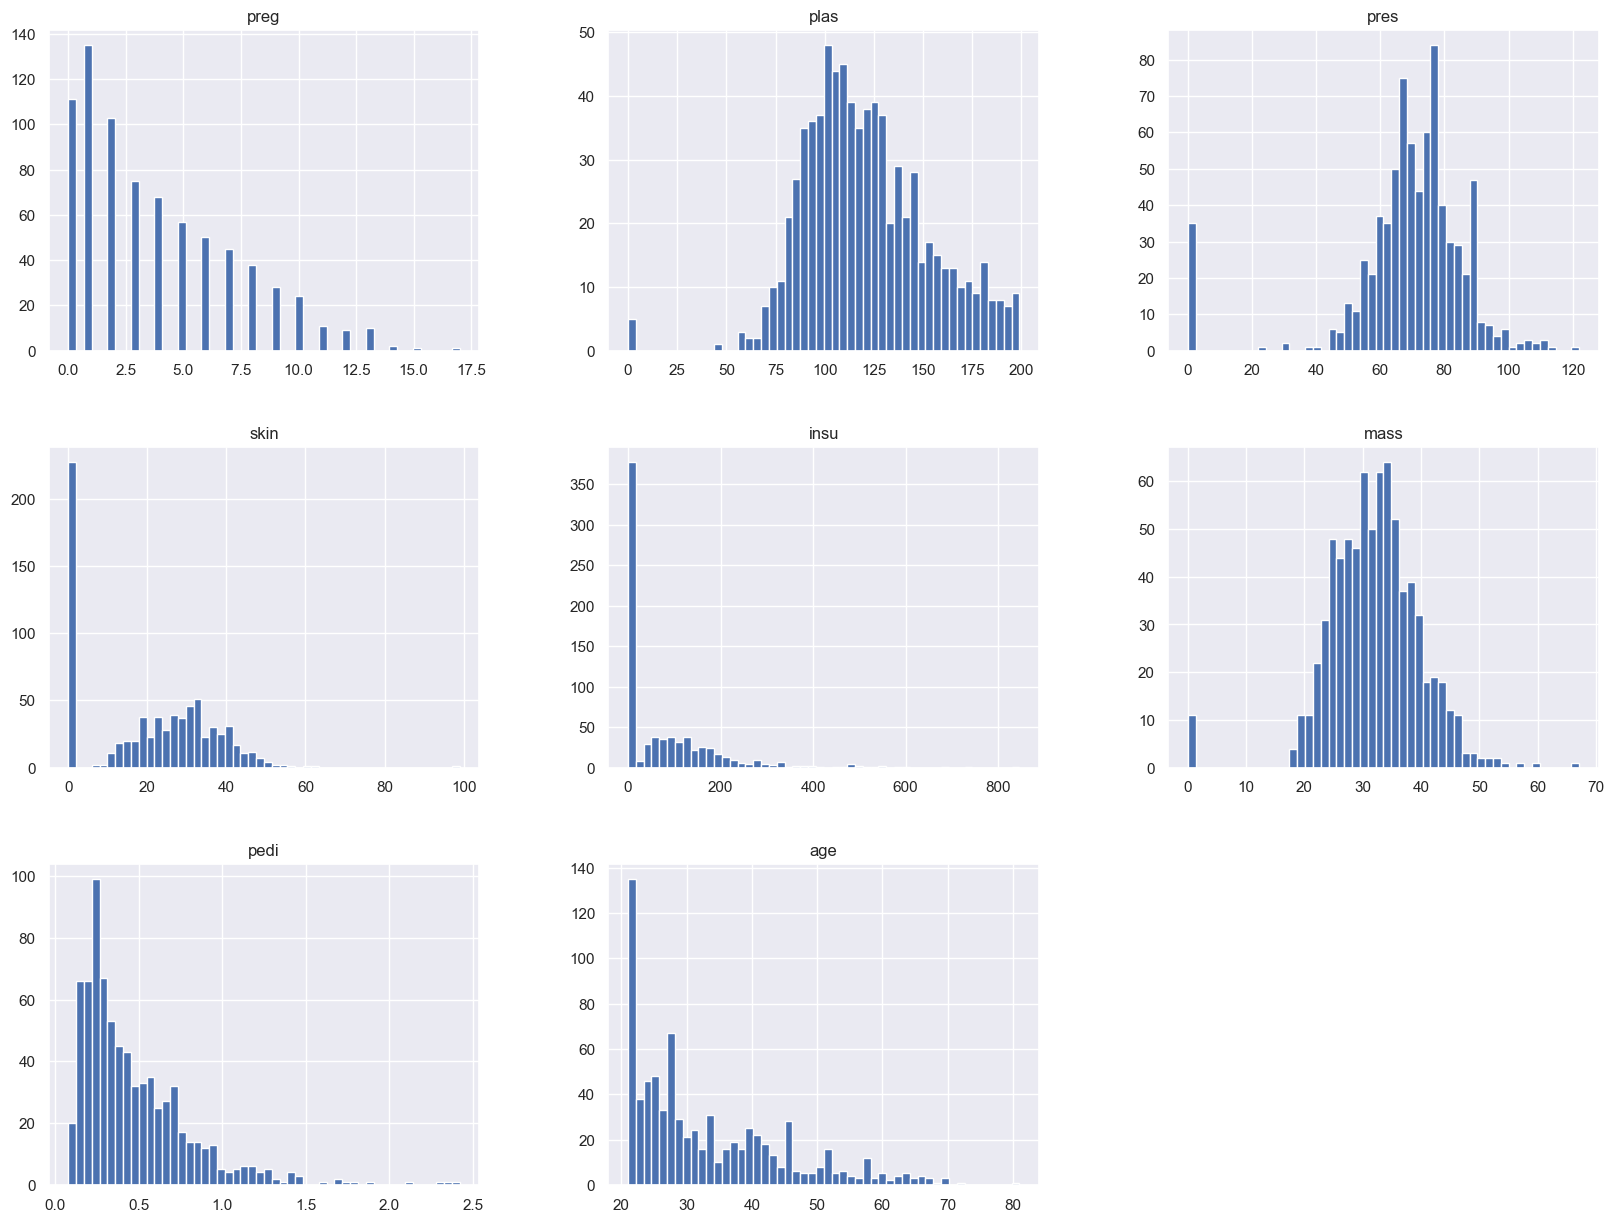

In [8]:
# Histogram:distribution of a single numerical variable
numerical_variables_df.hist(bins=50, figsize=(20, 15))
plt.show()

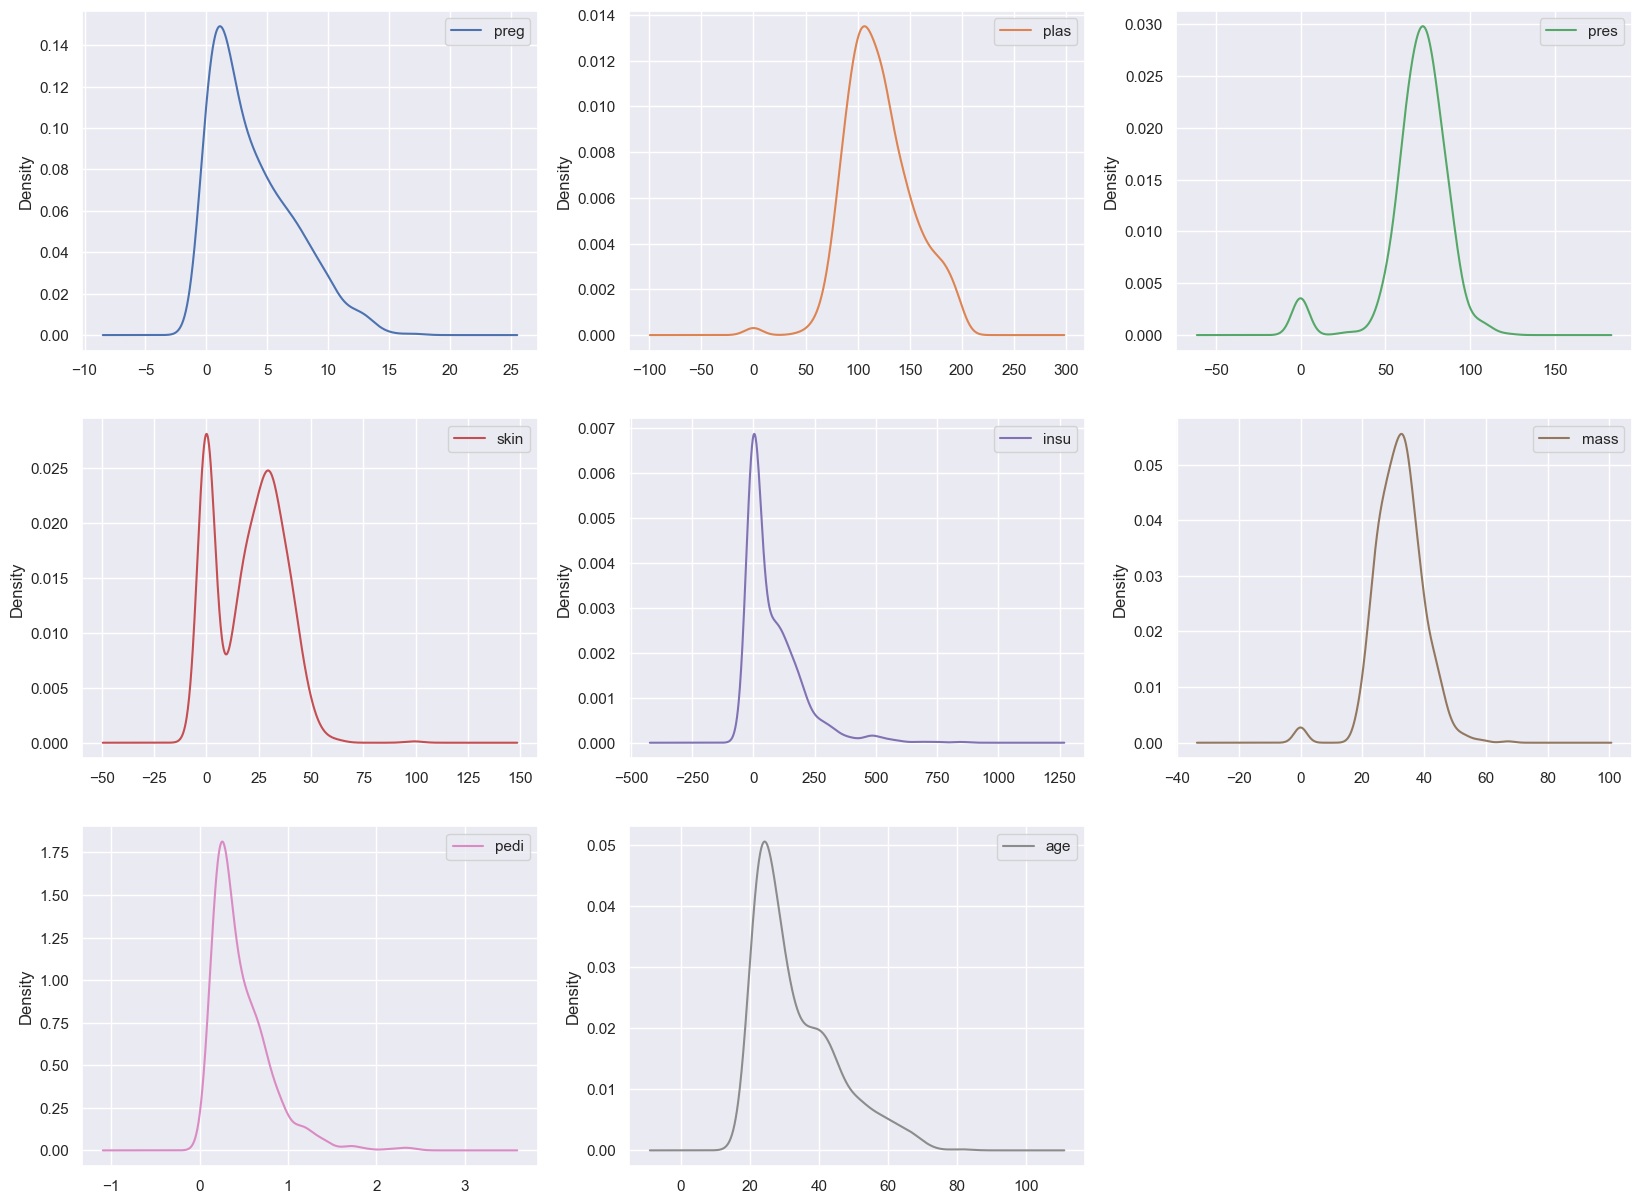

In [11]:
# Density plots for all attributes to visualize the distribution of each attribute
numerical_variables_df.plot(kind='density', subplots=True, layout=(3,3), figsize=(20, 15), sharex=False)
plt.show()

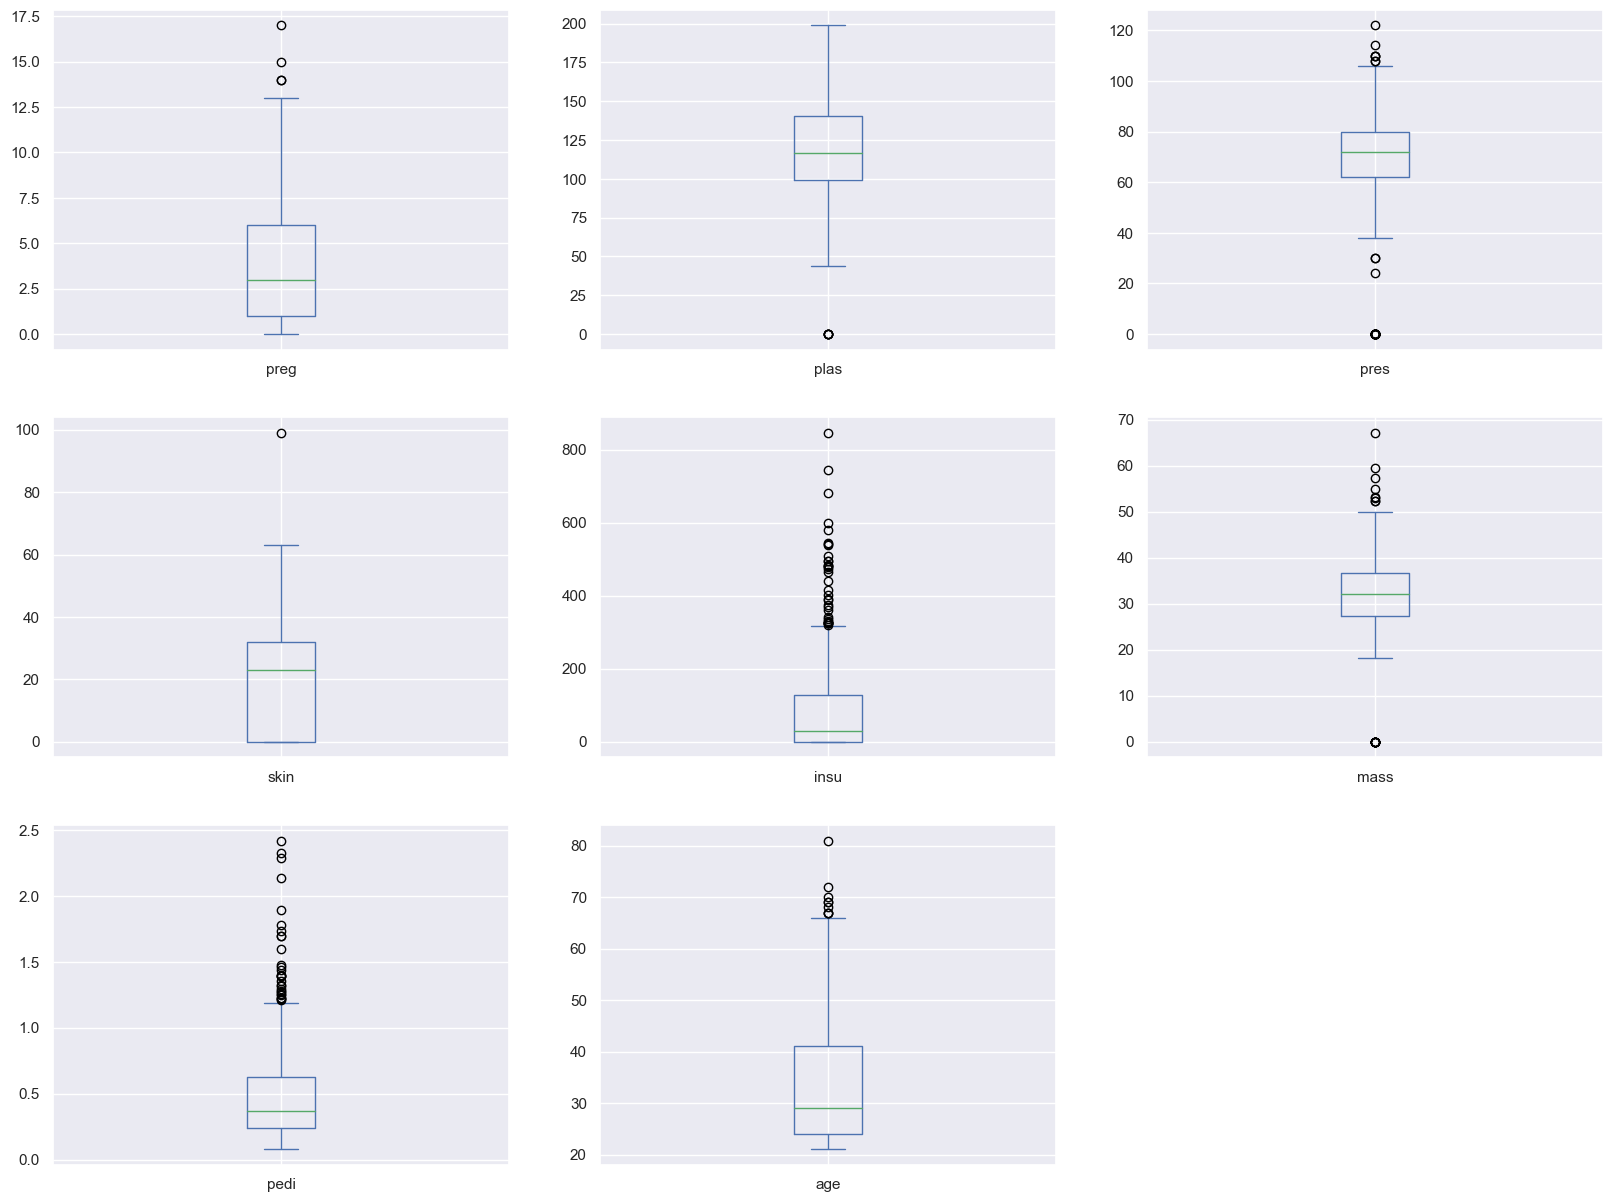

In [12]:
# Box Plot (Box-and-Whisker Plot): Summarizes the distribution of a numerical variable's
numerical_variables_df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20,15))
plt.show()

### observation : outlier is detected in all features

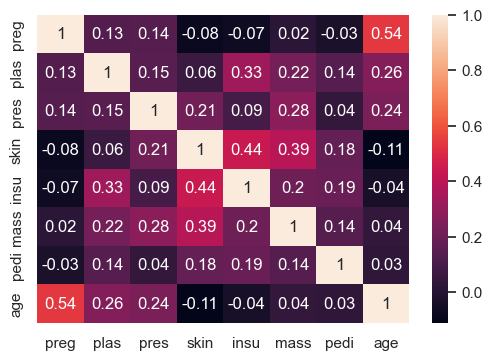

In [13]:
# Correlation between the different characteristics. Closer to 1 better is the correlation.
sns.heatmap(round(numerical_variables_df.corr(method='pearson'),2), annot = True)
plt.show()

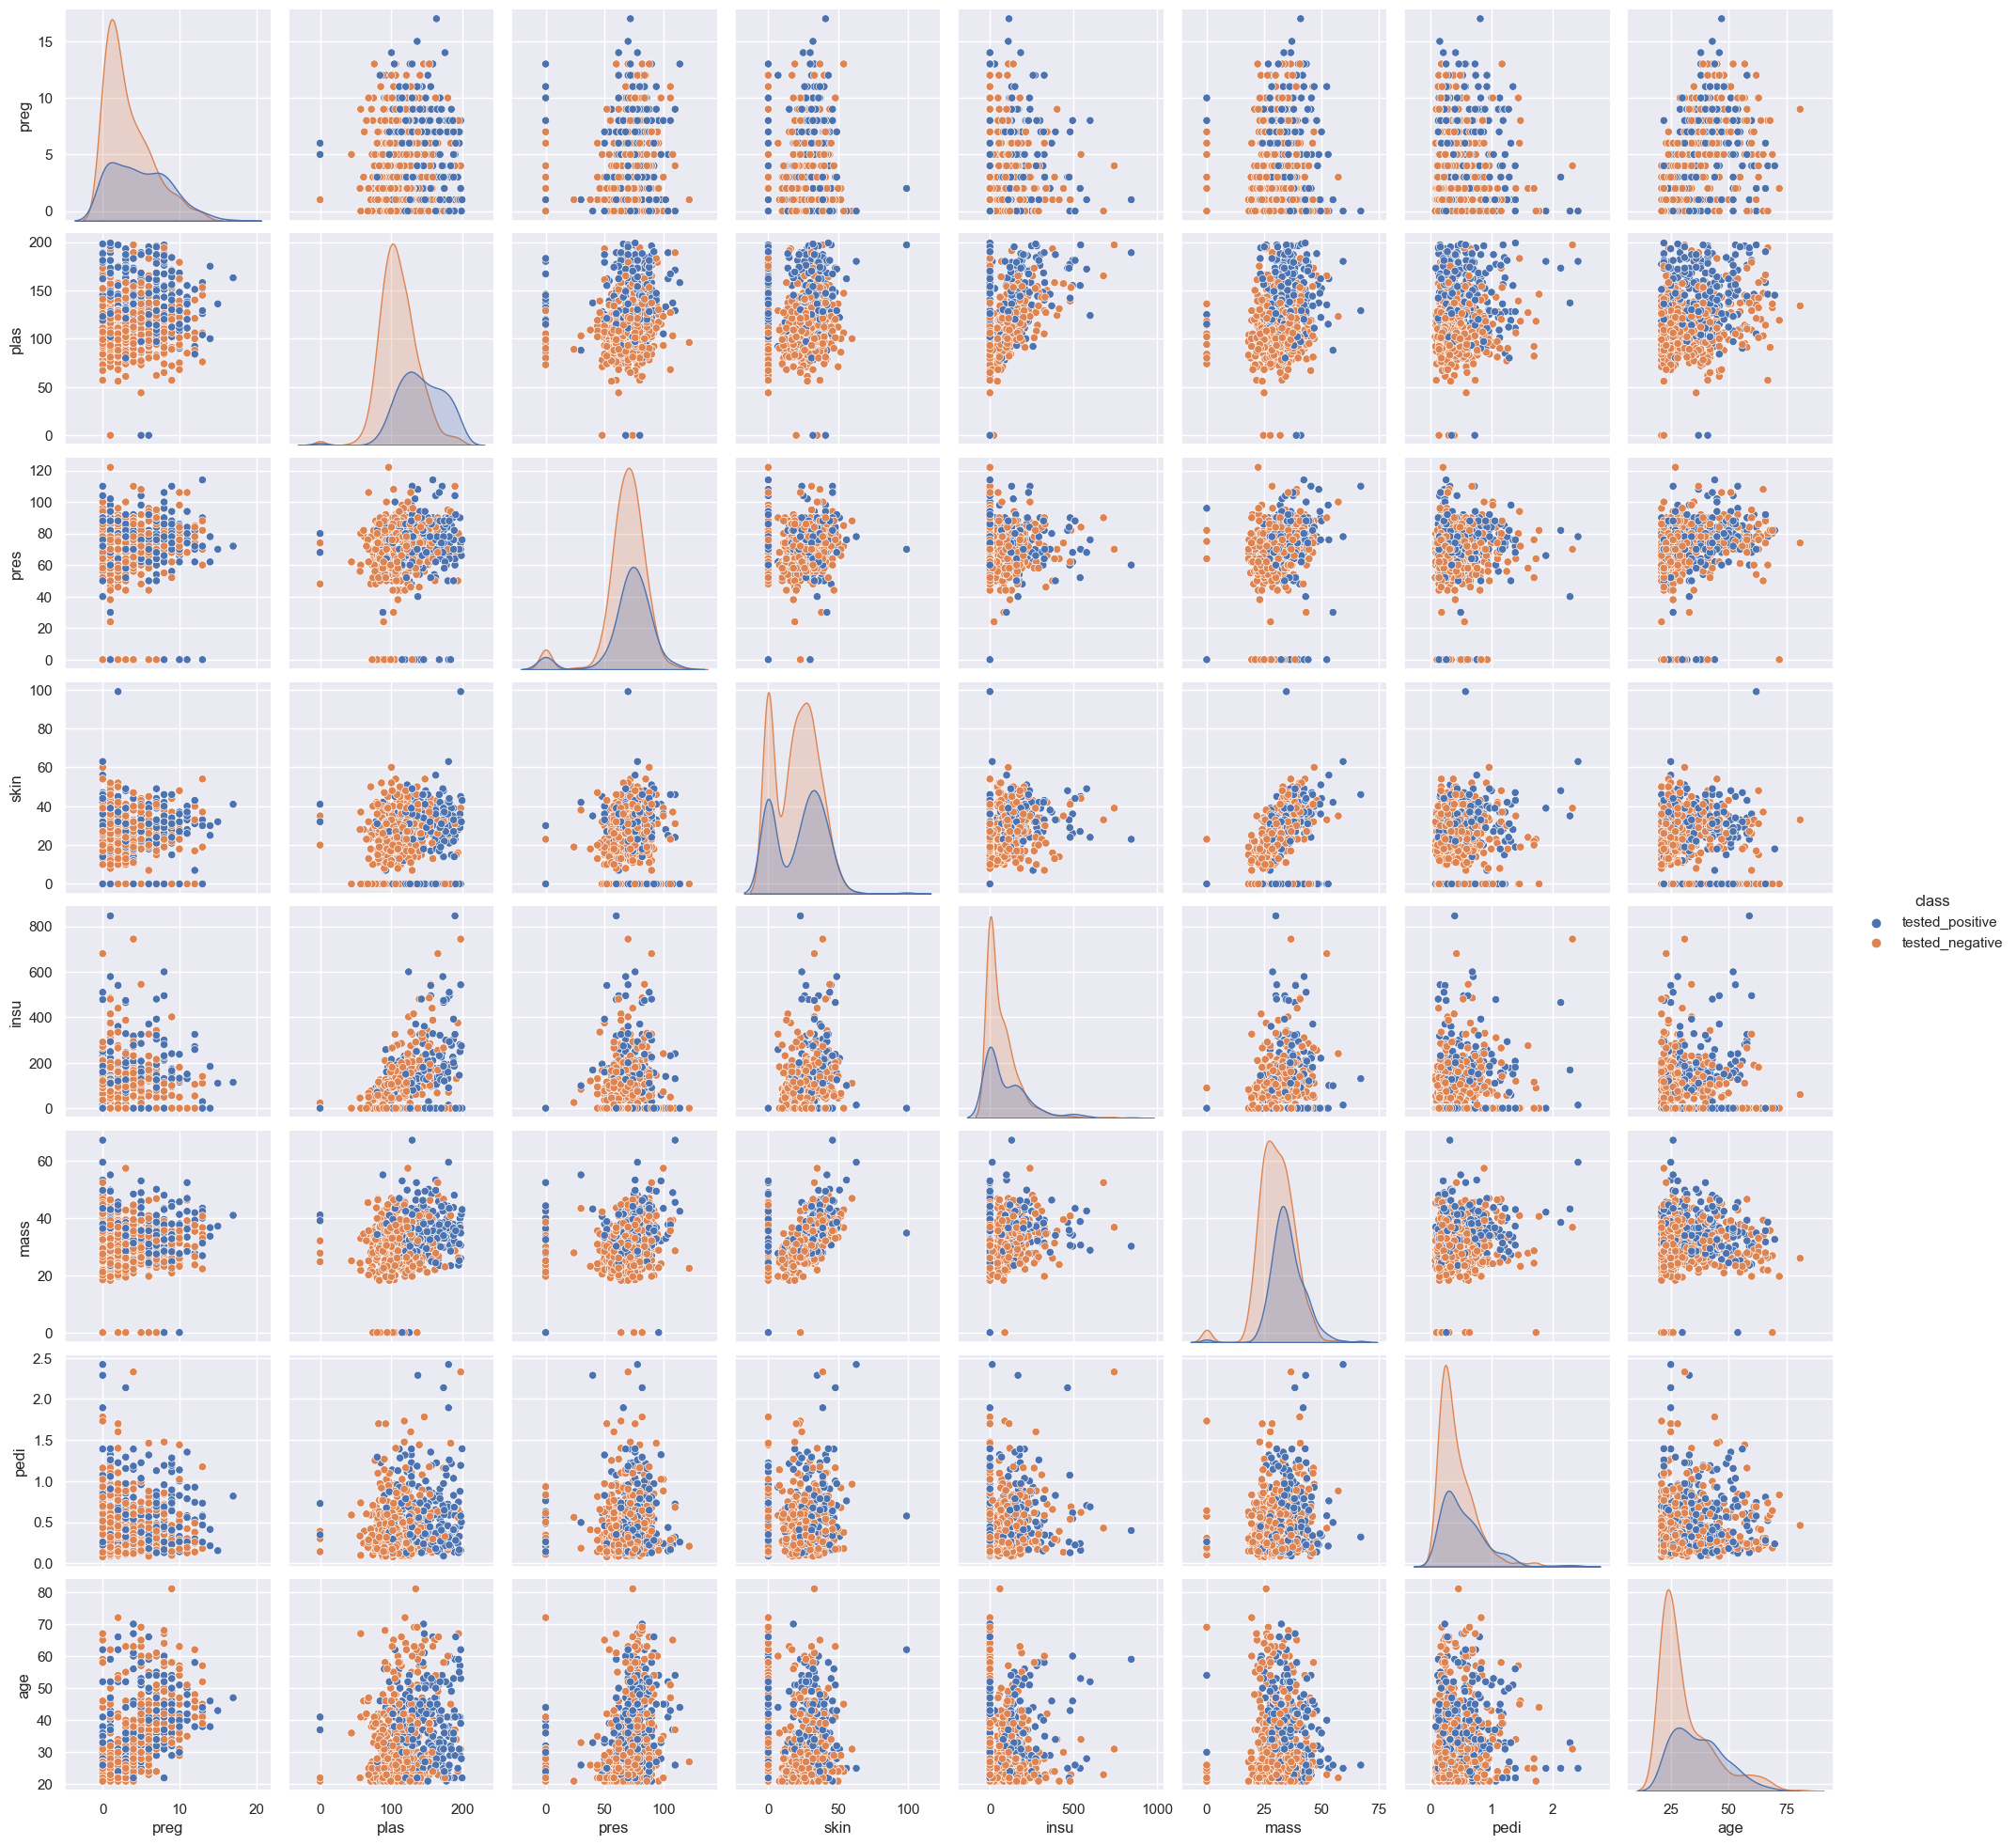

In [16]:
numerical_variables_df_class = pd.concat([numerical_variables_df, df['class']], axis=1)
# Pairplot
sns.pairplot(numerical_variables_df_class, hue='class')
plt.show()

In [17]:
df['classification'] = df['class'].apply(lambda x: 1 if x=='tested_negative' else 0)
# Remove two columns name is 'class'
df.drop(['class'], axis=1, inplace=True)
df.head(10)

,preg,plas,pres,skin,insu,mass,pedi,age,classification
0,6,148,72,35,0,33.6,0.627,50,0
1,1,85,66,29,0,26.6,0.351,31,1
2,8,183,64,0,0,23.3,0.672,32,0
3,1,89,66,23,94,28.1,0.167,21,1
4,0,137,40,35,168,43.1,2.288,33,0
5,5,116,74,0,0,25.6,0.201,30,1
6,3,78,50,32,88,31.0,0.248,26,0
7,10,115,0,0,0,35.3,0.134,29,1
8,2,197,70,45,543,30.5,0.158,53,0
9,8,125,96,0,0,0.0,0.232,54,0


# Remove Outlier using IQR

In [18]:
def remove_outliers_iqr_all_columns(df):
    # Create an empty DataFrame to store filtered data
    filtered_df = pd.DataFrame()

    # Iterate through each column in the input DataFrame
    for col in df.columns:
        # Calculate the first quartile (Q1) and third quartile (Q3) for the column
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        # Calculate the IQR (Interquartile Range) for the column
        iqr = q3 - q1

        # Define the lower and upper bounds to identify outliers for the column
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Remove outliers from the column and add it to the filtered DataFrame
        filtered_df[col] = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col]
        
        # Drop nan value from the column and add it to the filtered DataFrame
        filtered_df = filtered_df.dropna(axis=0).reset_index(drop=True)
        
    return filtered_df

df = remove_outliers_iqr_all_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   preg            629 non-null    int64  
 1   plas            629 non-null    float64
 2   pres            629 non-null    float64
 3   skin            629 non-null    float64
 4   insu            629 non-null    float64
 5   mass            629 non-null    float64
 6   pedi            629 non-null    float64
 7   age             629 non-null    float64
 8   classification  629 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 44.4 KB


# Check SMOTE for Imbalanced Classification

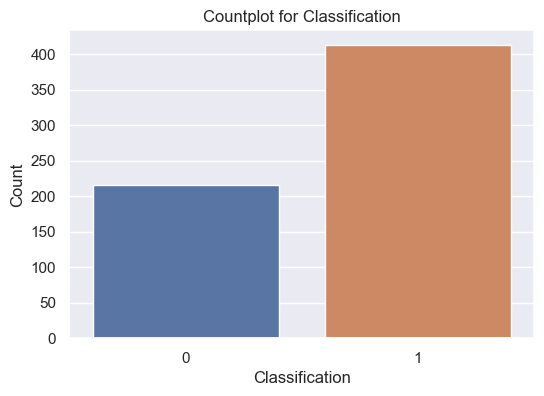

In [19]:
# Check If A Dataset Is Imbalanced
sns.countplot(x=df["classification"])
plt.title('Countplot for Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

In [20]:
y = df['classification']

# summarize class distribution
counter = Counter(y)
print(f"Classification class distribution : {counter}")

# summarize class proportion
unique_labels, counts = np.unique(y, return_counts=True)
proportions = (counts / len(y))*100
print(f"Proportion of samples in each class (0,1) : {proportions}")

Classification class distribution : Counter({1: 413, 0: 216})
Proportion of samples in each class (0,1) : [34.34022258 65.65977742]


In [21]:
# get unique values from columns
caltegorical_feature, numarical_feature =[], []
for col in df.columns:
    print(f"Unique values in {col} is : {sorted(df[col].unique())}, Count : {len(sorted(df[col].unique()))}")
    if len(sorted(df[col].unique())) > 150:
        numarical_feature.append(col)
    else:
        caltegorical_feature.append(col)
        
print(f"Numarical features : {numarical_feature}")
print(f"Caltegorical features : {caltegorical_feature}")

Unique values in preg is : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], Count : 14
Unique values in plas is : [44.0, 56.0, 57.0, 61.0, 62.0, 65.0, 67.0, 68.0, 71.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 183.0, 184.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0

In [22]:
from imblearn.over_sampling import SMOTE

# split data into X, y
X, y = df.drop(['classification'], axis = 1),  df['classification']

# fit data in oversample
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# concat data in df
df = pd.concat([X, y], axis=1)

# change data type
for col in caltegorical_feature:
    df[col] = df[col].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   preg            826 non-null    int32  
 1   plas            826 non-null    int32  
 2   pres            826 non-null    int32  
 3   skin            826 non-null    int32  
 4   insu            826 non-null    int32  
 5   mass            826 non-null    float64
 6   pedi            826 non-null    float64
 7   age             826 non-null    int32  
 8   classification  826 non-null    int32  
dtypes: float64(2), int32(7)
memory usage: 35.6 KB


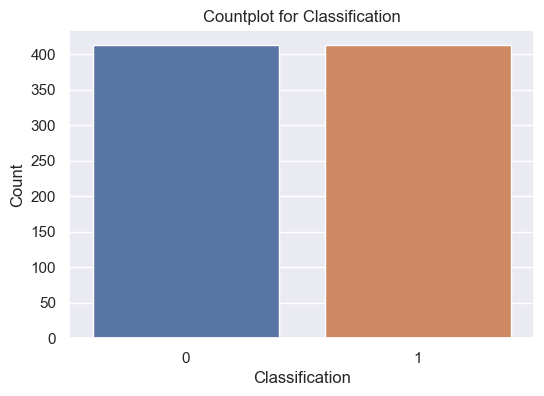

In [23]:
# Check If A Dataset Is Imbalanced
sns.countplot(x=df["classification"])
plt.title('Countplot for Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

In [24]:
y = df['classification']

# summarize class distribution
counter = Counter(y)
print(f"Classification class distribution : {counter}")

# summarize class proportion
unique_labels, counts = np.unique(y, return_counts=True)
proportions = (counts / len(y))*100
print(f"Proportion of samples in each class (0,1) : {proportions}")

Classification class distribution : Counter({0: 413, 1: 413})
Proportion of samples in each class (0,1) : [50. 50.]


In [25]:
dataset = df
dataset.head()

,preg,plas,pres,skin,insu,mass,pedi,age,classification
0,6,148,72,35,0,33.6,0.627,50,0
1,1,85,66,29,0,26.6,0.351,31,1
2,8,183,64,0,0,23.3,0.672,32,0
3,1,89,66,23,94,28.1,0.167,21,1
4,5,116,74,0,0,25.6,0.201,33,0


# Classification

In [26]:
X, Y = dataset.drop(['classification'], axis = 1),  dataset['classification']
# train_test_split 80/20
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42, stratify = Y)

In [27]:
# Model initialization
lr_Classifier = LogisticRegression()
knn_Classifier = KNeighborsClassifier()
gnb_Classifier = GaussianNB()
dt_Classifier = DecisionTreeClassifier()
rf_Classifier = RandomForestClassifier()
model_list = [lr_Classifier, knn_Classifier, gnb_Classifier, dt_Classifier, rf_Classifier]

# Scaler initialization
MinMax_scaler = MinMaxScaler()
Standard_scaler = StandardScaler()
MaxAbs_scaler = MaxAbsScaler()
Robust_scaler = RobustScaler()
Quantile_scaler = QuantileTransformer()
Power_scaler = PowerTransformer()
Normalizer_scaler = Normalizer()
scaler_list = [MinMax_scaler, Standard_scaler, MaxAbs_scaler, Robust_scaler, 
               Quantile_scaler, Power_scaler, Normalizer_scaler]

In [28]:
def run_pipeline(X_train, X_test, y_train, y_test, scaler, classifier):
    # Model Information
    print(f"Modele name : {type(classifier).__name__}")
    print(f"Scaler name : {type(scaler).__name__}")
    
    # process 1 : fit and transform X_train data
    scaled_X_train = scaler.fit_transform(X_train)
    
    # process 2 : train model
    classifier.fit(scaled_X_train, y_train)   
    
    # process 3 : transform X_test data
    scaled_X_test = scaler.transform(X_test)
    
    # process 4 : test model
    y_pred = classifier.predict(scaled_X_test)
    # print(y_pred, le.inverse_transform(y_pred))
    
    # process 5 : Perform k-fold cross-validation using cross_val_score
    scores = cross_val_score(classifier, scaled_X_train, y_train, cv=10, scoring='accuracy')
    print(f"10 K-Fold Accuracy_score : {np.round_(scores,4)}")
    print(f"10 K-Fold Average Accuracy_score : {round(np.average(scores)*100,2)} %")
    
    # process 6 : model evalution
    print("Accuracy_score:", round((accuracy_score(y_test, y_pred))*100,2),'%')
    print("Loss:", round((1-accuracy_score(y_test, y_pred))*100,2),'%')
    print("Cohen_kappa_score:", round((cohen_kappa_score(y_test, y_pred))*100,2),'%')
    print("Classification_report:\n",metrics.classification_report(y_test, y_pred))
    print("confusion_matrix:\n", confusion_matrix(y_test, y_pred))
    # plot confusion_matrix
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4) # WH
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True,
                fmt=".1f",
                linewidths = 2,
                linecolor = "blue",
                center=0)
    plt.show()
    print("Root Mean Square Error (RMSE):", round(sqrt(mean_squared_error(y_test, y_pred)), 4))
    
    # process 7 : save model in pkl file
    filename = f'Moduls\\{str(type(classifier).__name__)}_{str(type(scaler).__name__)}_01_LS_Disease_Prediction.pkl'
    pickle.dump(classifier, open(filename, 'wb'))
    
    # collect data for bar plot
    global plot_data_list
    plot_data_list.append([str(type(classifier).__name__), 
                           str(type(scaler).__name__), 
                           round((accuracy_score(y_test, y_pred))*100,2)])
    
    # collect data for bar plot (RSME)
    global plot_RSME_list
    plot_RSME_list.append([str(type(classifier).__name__), 
                           str(type(scaler).__name__), 
                           round(sqrt(mean_squared_error(y_test, y_pred)), 4)])
    
    # end 
    print("==="*30)
    print("\n\n")
    time.sleep(0.5)

Modele name : LogisticRegression
Scaler name : MinMaxScaler
10 K-Fold Accuracy_score : [0.5606 0.6667 0.5758 0.5909 0.4848 0.5    0.5455 0.5    0.6061 0.4848]
10 K-Fold Average Accuracy_score : 55.15 %
Accuracy_score: 51.2 %
Loss: 48.8 %
Cohen_kappa_score: 2.41 %
Classification_report:
               precision    recall  f1-score   support

           0       0.51      0.53      0.52        83
           1       0.51      0.49      0.50        83

    accuracy                           0.51       166
   macro avg       0.51      0.51      0.51       166
weighted avg       0.51      0.51      0.51       166

confusion_matrix:
 [[44 39]
 [42 41]]


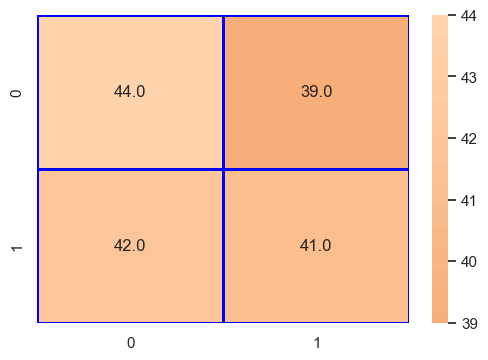

Root Mean Square Error (RMSE): 0.6985



Modele name : LogisticRegression
Scaler name : StandardScaler
10 K-Fold Accuracy_score : [0.5606 0.6212 0.5758 0.5758 0.5    0.5    0.5606 0.4848 0.6061 0.5   ]
10 K-Fold Average Accuracy_score : 54.85 %
Accuracy_score: 50.6 %
Loss: 49.4 %
Cohen_kappa_score: 1.2 %
Classification_report:
               precision    recall  f1-score   support

           0       0.51      0.53      0.52        83
           1       0.51      0.48      0.49        83

    accuracy                           0.51       166
   macro avg       0.51      0.51      0.51       166
weighted avg       0.51      0.51      0.51       166

confusion_matrix:
 [[44 39]
 [43 40]]


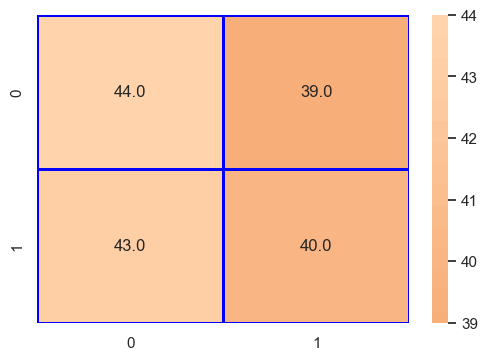

Root Mean Square Error (RMSE): 0.7028



Modele name : LogisticRegression
Scaler name : MaxAbsScaler
10 K-Fold Accuracy_score : [0.5303 0.6667 0.6061 0.5758 0.5    0.5    0.5909 0.5152 0.5909 0.5   ]
10 K-Fold Average Accuracy_score : 55.76 %
Accuracy_score: 50.6 %
Loss: 49.4 %
Cohen_kappa_score: 1.2 %
Classification_report:
               precision    recall  f1-score   support

           0       0.51      0.52      0.51        83
           1       0.51      0.49      0.50        83

    accuracy                           0.51       166
   macro avg       0.51      0.51      0.51       166
weighted avg       0.51      0.51      0.51       166

confusion_matrix:
 [[43 40]
 [42 41]]


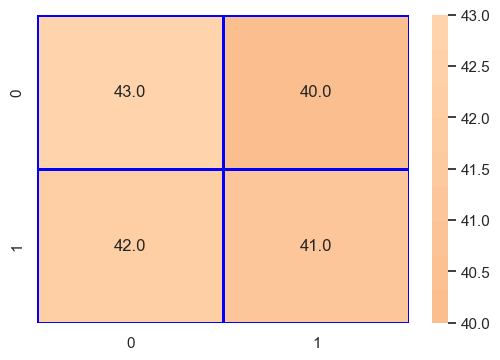

Root Mean Square Error (RMSE): 0.7028



Modele name : LogisticRegression
Scaler name : RobustScaler
10 K-Fold Accuracy_score : [0.5606 0.6212 0.5758 0.5758 0.4848 0.5    0.5455 0.4848 0.6061 0.4848]
10 K-Fold Average Accuracy_score : 54.39 %
Accuracy_score: 50.0 %
Loss: 50.0 %
Cohen_kappa_score: 0.0 %
Classification_report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51        83
           1       0.50      0.48      0.49        83

    accuracy                           0.50       166
   macro avg       0.50      0.50      0.50       166
weighted avg       0.50      0.50      0.50       166

confusion_matrix:
 [[43 40]
 [43 40]]


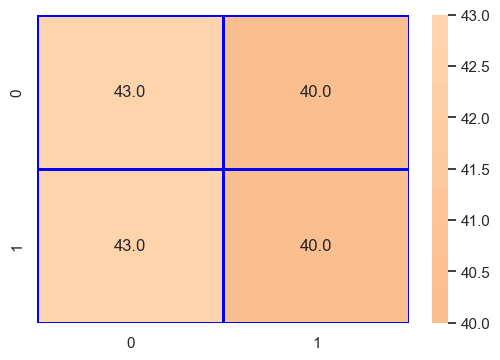

Root Mean Square Error (RMSE): 0.7071



Modele name : LogisticRegression
Scaler name : QuantileTransformer
10 K-Fold Accuracy_score : [0.5758 0.6212 0.6515 0.6061 0.5303 0.5303 0.5758 0.5    0.5758 0.5   ]
10 K-Fold Average Accuracy_score : 56.67 %
Accuracy_score: 54.22 %
Loss: 45.78 %
Cohen_kappa_score: 8.43 %
Classification_report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56        83
           1       0.55      0.51      0.52        83

    accuracy                           0.54       166
   macro avg       0.54      0.54      0.54       166
weighted avg       0.54      0.54      0.54       166

confusion_matrix:
 [[48 35]
 [41 42]]


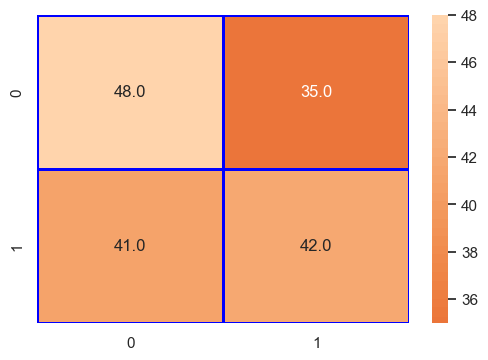

Root Mean Square Error (RMSE): 0.6766



Modele name : LogisticRegression
Scaler name : PowerTransformer
10 K-Fold Accuracy_score : [0.6061 0.6212 0.6667 0.5606 0.5152 0.5303 0.5606 0.5152 0.6061 0.5152]
10 K-Fold Average Accuracy_score : 56.97 %
Accuracy_score: 53.61 %
Loss: 46.39 %
Cohen_kappa_score: 7.23 %
Classification_report:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55        83
           1       0.54      0.51      0.52        83

    accuracy                           0.54       166
   macro avg       0.54      0.54      0.54       166
weighted avg       0.54      0.54      0.54       166

confusion_matrix:
 [[47 36]
 [41 42]]


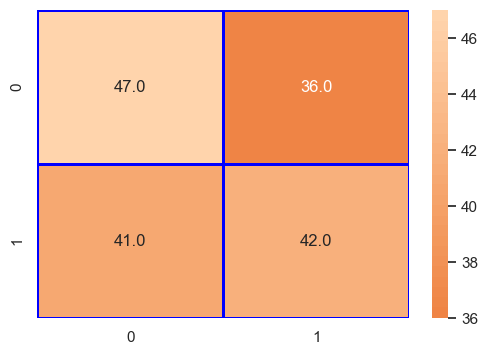

Root Mean Square Error (RMSE): 0.6811



Modele name : LogisticRegression
Scaler name : Normalizer
10 K-Fold Accuracy_score : [0.5303 0.5455 0.5758 0.5909 0.6212 0.3939 0.5606 0.4091 0.5152 0.4697]
10 K-Fold Average Accuracy_score : 52.12 %
Accuracy_score: 52.41 %
Loss: 47.59 %
Cohen_kappa_score: 4.82 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53        83
           1       0.52      0.52      0.52        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[44 39]
 [40 43]]


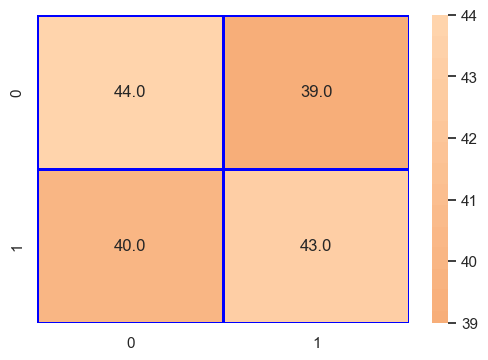

Root Mean Square Error (RMSE): 0.6899





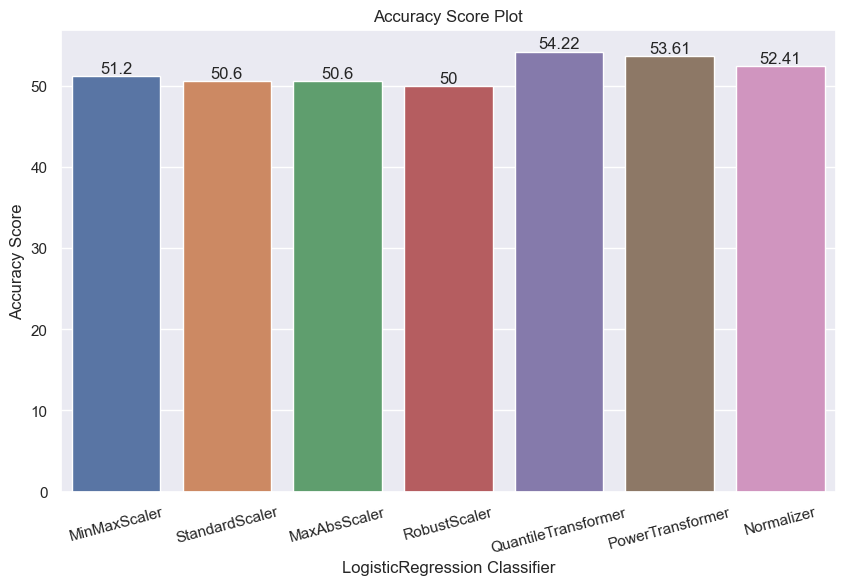

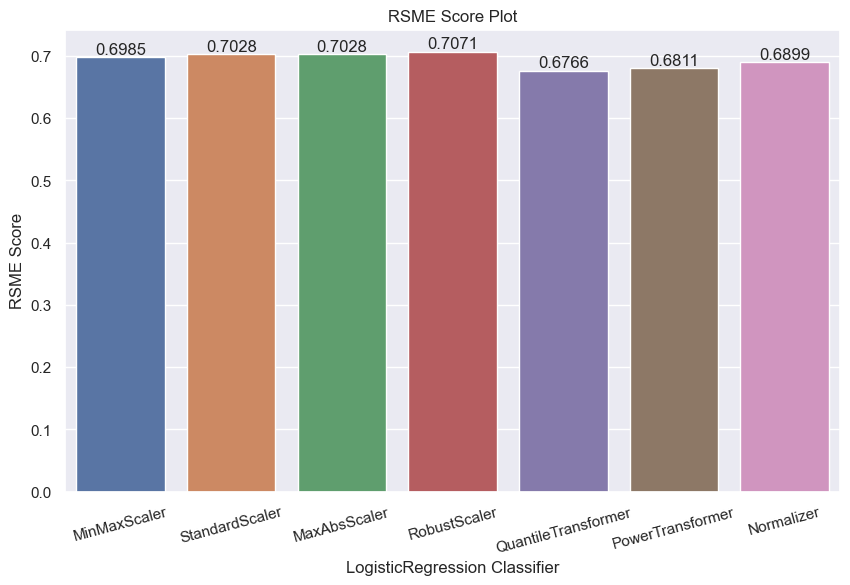




Modele name : KNeighborsClassifier
Scaler name : MinMaxScaler
10 K-Fold Accuracy_score : [0.5    0.5152 0.6212 0.5758 0.5758 0.5152 0.5909 0.5606 0.6364 0.6061]
10 K-Fold Average Accuracy_score : 56.97 %
Accuracy_score: 63.25 %
Loss: 36.75 %
Cohen_kappa_score: 26.51 %
Classification_report:
               precision    recall  f1-score   support

           0       0.61      0.72      0.66        83
           1       0.66      0.54      0.60        83

    accuracy                           0.63       166
   macro avg       0.64      0.63      0.63       166
weighted avg       0.64      0.63      0.63       166

confusion_matrix:
 [[60 23]
 [38 45]]


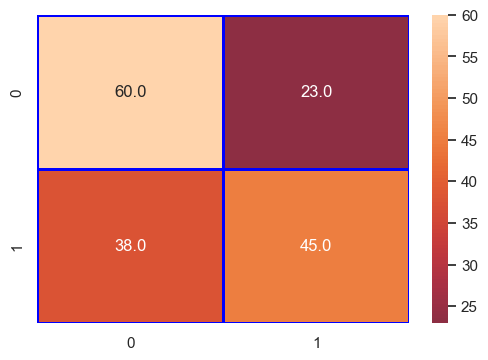

Root Mean Square Error (RMSE): 0.6062



Modele name : KNeighborsClassifier
Scaler name : StandardScaler
10 K-Fold Accuracy_score : [0.4848 0.5303 0.6212 0.5758 0.5606 0.5152 0.6364 0.5606 0.6515 0.5758]
10 K-Fold Average Accuracy_score : 57.12 %
Accuracy_score: 60.84 %
Loss: 39.16 %
Cohen_kappa_score: 21.69 %
Classification_report:
               precision    recall  f1-score   support

           0       0.59      0.72      0.65        83
           1       0.64      0.49      0.56        83

    accuracy                           0.61       166
   macro avg       0.61      0.61      0.60       166
weighted avg       0.61      0.61      0.60       166

confusion_matrix:
 [[60 23]
 [42 41]]


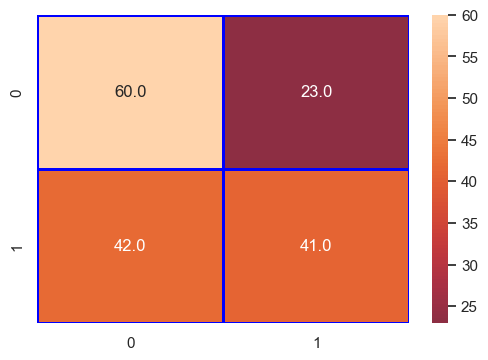

Root Mean Square Error (RMSE): 0.6258



Modele name : KNeighborsClassifier
Scaler name : MaxAbsScaler
10 K-Fold Accuracy_score : [0.5303 0.5758 0.5909 0.5909 0.6364 0.5455 0.5909 0.5909 0.6667 0.6212]
10 K-Fold Average Accuracy_score : 59.39 %
Accuracy_score: 62.05 %
Loss: 37.95 %
Cohen_kappa_score: 24.1 %
Classification_report:
               precision    recall  f1-score   support

           0       0.60      0.70      0.65        83
           1       0.64      0.54      0.59        83

    accuracy                           0.62       166
   macro avg       0.62      0.62      0.62       166
weighted avg       0.62      0.62      0.62       166

confusion_matrix:
 [[58 25]
 [38 45]]


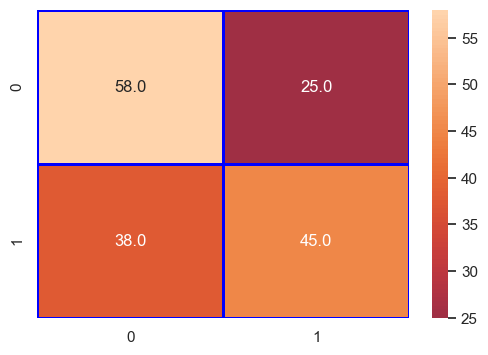

Root Mean Square Error (RMSE): 0.6161



Modele name : KNeighborsClassifier
Scaler name : RobustScaler
10 K-Fold Accuracy_score : [0.5    0.5606 0.6818 0.6364 0.5606 0.5303 0.6061 0.5758 0.5758 0.5909]
10 K-Fold Average Accuracy_score : 58.18 %
Accuracy_score: 60.24 %
Loss: 39.76 %
Cohen_kappa_score: 20.48 %
Classification_report:
               precision    recall  f1-score   support

           0       0.59      0.66      0.62        83
           1       0.62      0.54      0.58        83

    accuracy                           0.60       166
   macro avg       0.60      0.60      0.60       166
weighted avg       0.60      0.60      0.60       166

confusion_matrix:
 [[55 28]
 [38 45]]


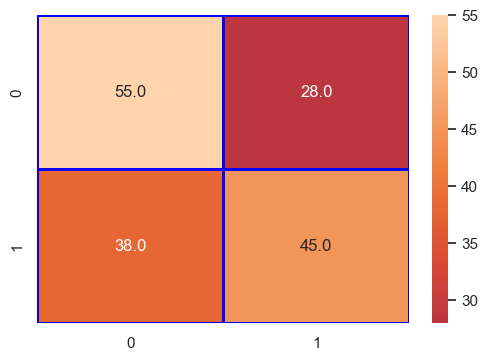

Root Mean Square Error (RMSE): 0.6305



Modele name : KNeighborsClassifier
Scaler name : QuantileTransformer
10 K-Fold Accuracy_score : [0.4848 0.5758 0.6515 0.6515 0.7273 0.6667 0.5909 0.6061 0.6667 0.5758]
10 K-Fold Average Accuracy_score : 61.97 %
Accuracy_score: 60.84 %
Loss: 39.16 %
Cohen_kappa_score: 21.69 %
Classification_report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.66        83
           1       0.65      0.47      0.55        83

    accuracy                           0.61       166
   macro avg       0.62      0.61      0.60       166
weighted avg       0.62      0.61      0.60       166

confusion_matrix:
 [[62 21]
 [44 39]]


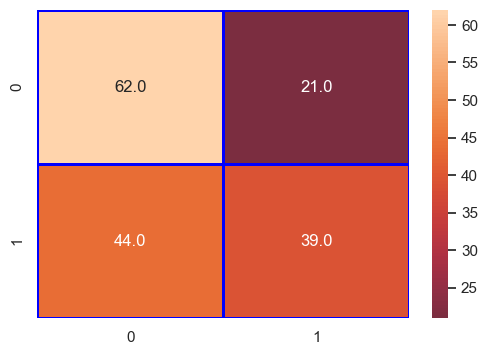

Root Mean Square Error (RMSE): 0.6258



Modele name : KNeighborsClassifier
Scaler name : PowerTransformer
10 K-Fold Accuracy_score : [0.5    0.5909 0.6667 0.5758 0.7121 0.6061 0.6212 0.5758 0.6364 0.4697]
10 K-Fold Average Accuracy_score : 59.55 %
Accuracy_score: 61.45 %
Loss: 38.55 %
Cohen_kappa_score: 22.89 %
Classification_report:
               precision    recall  f1-score   support

           0       0.59      0.77      0.67        83
           1       0.67      0.46      0.54        83

    accuracy                           0.61       166
   macro avg       0.63      0.61      0.60       166
weighted avg       0.63      0.61      0.60       166

confusion_matrix:
 [[64 19]
 [45 38]]


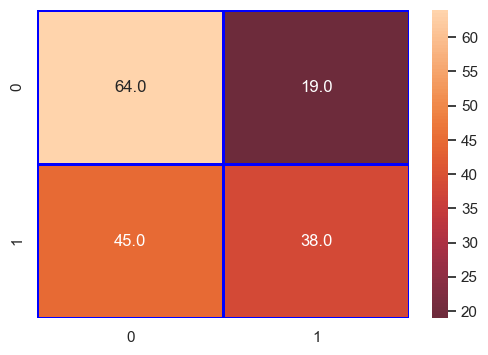

Root Mean Square Error (RMSE): 0.6209



Modele name : KNeighborsClassifier
Scaler name : Normalizer
10 K-Fold Accuracy_score : [0.5606 0.5909 0.7121 0.6061 0.697  0.5909 0.6212 0.5909 0.6515 0.5606]
10 K-Fold Average Accuracy_score : 61.82 %
Accuracy_score: 63.86 %
Loss: 36.14 %
Cohen_kappa_score: 27.71 %
Classification_report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66        83
           1       0.66      0.57      0.61        83

    accuracy                           0.64       166
   macro avg       0.64      0.64      0.64       166
weighted avg       0.64      0.64      0.64       166

confusion_matrix:
 [[59 24]
 [36 47]]


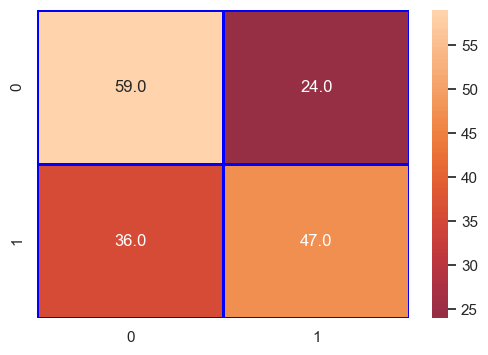

Root Mean Square Error (RMSE): 0.6012





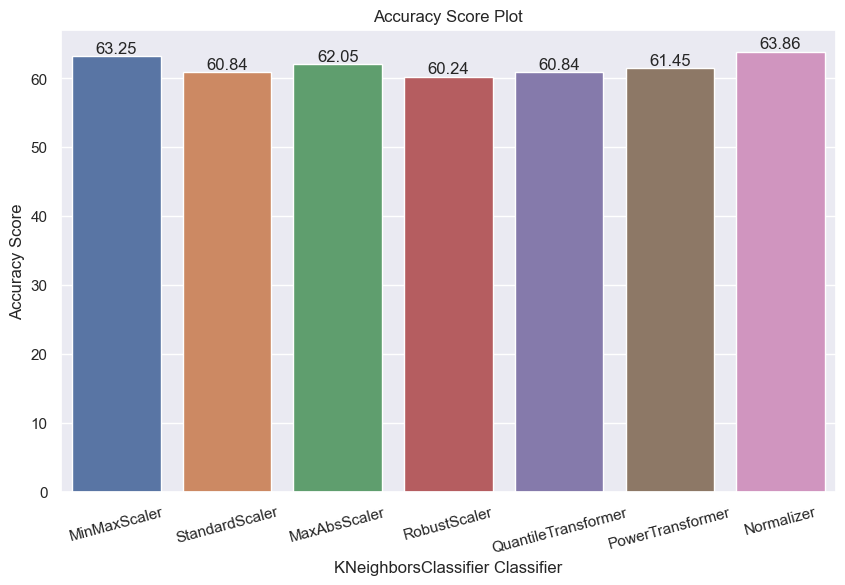

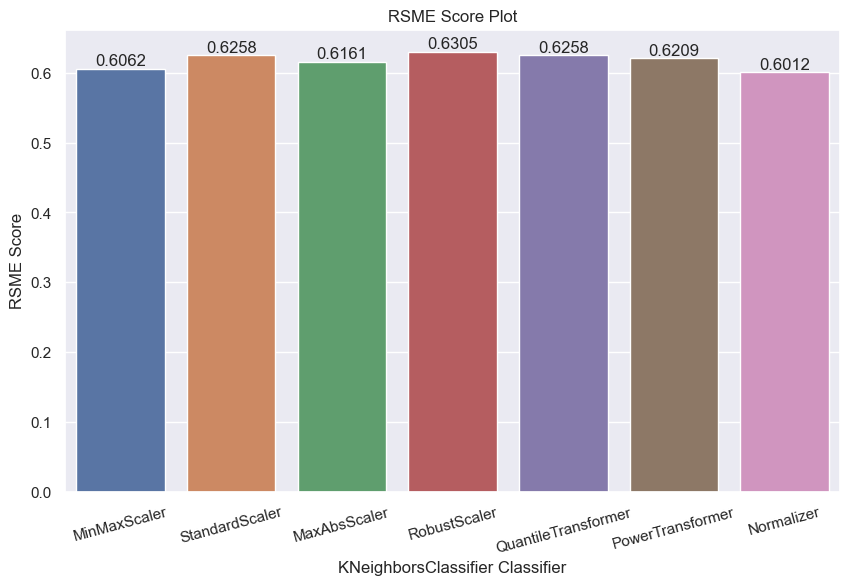




Modele name : GaussianNB
Scaler name : MinMaxScaler
10 K-Fold Accuracy_score : [0.5455 0.6212 0.5909 0.5455 0.5909 0.4697 0.5303 0.5455 0.5758 0.5   ]
10 K-Fold Average Accuracy_score : 55.15 %
Accuracy_score: 51.81 %
Loss: 48.19 %
Cohen_kappa_score: 3.61 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        83
           1       0.52      0.47      0.49        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[47 36]
 [44 39]]


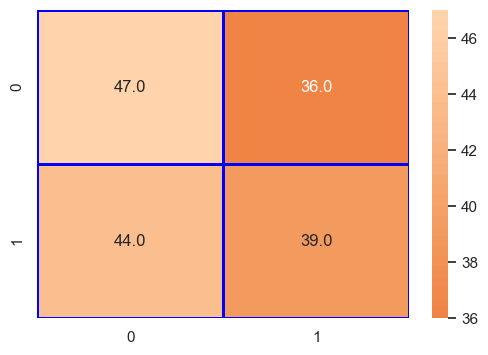

Root Mean Square Error (RMSE): 0.6942



Modele name : GaussianNB
Scaler name : StandardScaler
10 K-Fold Accuracy_score : [0.5455 0.6212 0.5909 0.5455 0.5909 0.4697 0.5303 0.5455 0.5758 0.5   ]
10 K-Fold Average Accuracy_score : 55.15 %
Accuracy_score: 51.81 %
Loss: 48.19 %
Cohen_kappa_score: 3.61 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        83
           1       0.52      0.47      0.49        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[47 36]
 [44 39]]


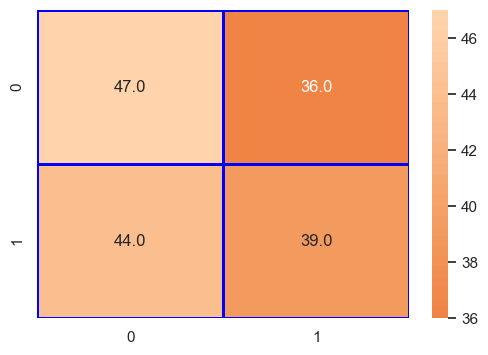

Root Mean Square Error (RMSE): 0.6942



Modele name : GaussianNB
Scaler name : MaxAbsScaler
10 K-Fold Accuracy_score : [0.5455 0.6212 0.5909 0.5455 0.5909 0.4697 0.5303 0.5455 0.5758 0.5   ]
10 K-Fold Average Accuracy_score : 55.15 %
Accuracy_score: 51.81 %
Loss: 48.19 %
Cohen_kappa_score: 3.61 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        83
           1       0.52      0.47      0.49        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[47 36]
 [44 39]]


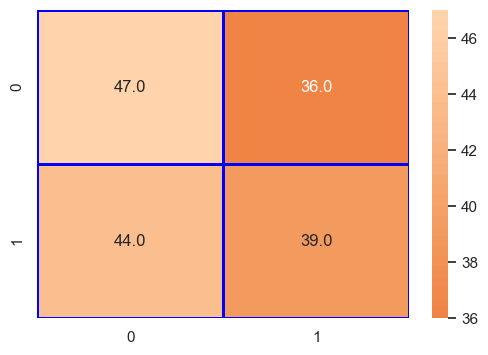

Root Mean Square Error (RMSE): 0.6942



Modele name : GaussianNB
Scaler name : RobustScaler
10 K-Fold Accuracy_score : [0.5455 0.6212 0.5909 0.5455 0.5909 0.4697 0.5303 0.5455 0.5758 0.5   ]
10 K-Fold Average Accuracy_score : 55.15 %
Accuracy_score: 51.81 %
Loss: 48.19 %
Cohen_kappa_score: 3.61 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        83
           1       0.52      0.47      0.49        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[47 36]
 [44 39]]


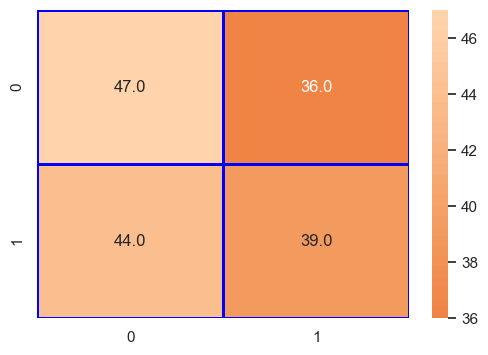

Root Mean Square Error (RMSE): 0.6942



Modele name : GaussianNB
Scaler name : QuantileTransformer
10 K-Fold Accuracy_score : [0.5455 0.6667 0.6515 0.6061 0.6061 0.5455 0.5    0.5303 0.6364 0.4848]
10 K-Fold Average Accuracy_score : 57.73 %
Accuracy_score: 54.82 %
Loss: 45.18 %
Cohen_kappa_score: 9.64 %
Classification_report:
               precision    recall  f1-score   support

           0       0.54      0.60      0.57        83
           1       0.55      0.49      0.52        83

    accuracy                           0.55       166
   macro avg       0.55      0.55      0.55       166
weighted avg       0.55      0.55      0.55       166

confusion_matrix:
 [[50 33]
 [42 41]]


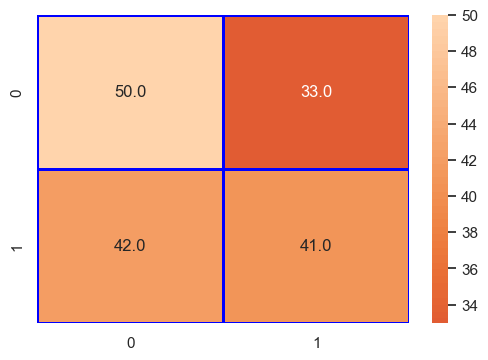

Root Mean Square Error (RMSE): 0.6722



Modele name : GaussianNB
Scaler name : PowerTransformer
10 K-Fold Accuracy_score : [0.5    0.6212 0.6515 0.6061 0.6061 0.5    0.5152 0.5    0.6364 0.5303]
10 K-Fold Average Accuracy_score : 56.67 %
Accuracy_score: 52.41 %
Loss: 47.59 %
Cohen_kappa_score: 4.82 %
Classification_report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        83
           1       0.53      0.48      0.50        83

    accuracy                           0.52       166
   macro avg       0.52      0.52      0.52       166
weighted avg       0.52      0.52      0.52       166

confusion_matrix:
 [[47 36]
 [43 40]]


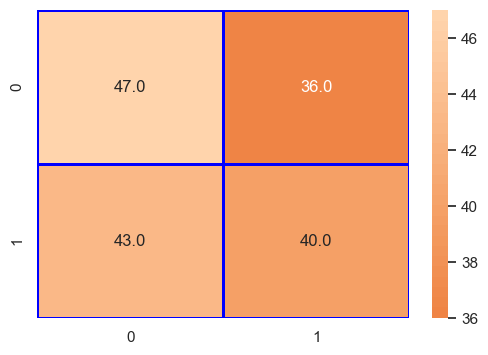

Root Mean Square Error (RMSE): 0.6899



Modele name : GaussianNB
Scaler name : Normalizer
10 K-Fold Accuracy_score : [0.6061 0.4848 0.5909 0.5152 0.5758 0.4242 0.5758 0.5455 0.5455 0.4394]
10 K-Fold Average Accuracy_score : 53.03 %
Accuracy_score: 48.8 %
Loss: 51.2 %
Cohen_kappa_score: -2.41 %
Classification_report:
               precision    recall  f1-score   support

           0       0.49      0.46      0.47        83
           1       0.49      0.52      0.50        83

    accuracy                           0.49       166
   macro avg       0.49      0.49      0.49       166
weighted avg       0.49      0.49      0.49       166

confusion_matrix:
 [[38 45]
 [40 43]]


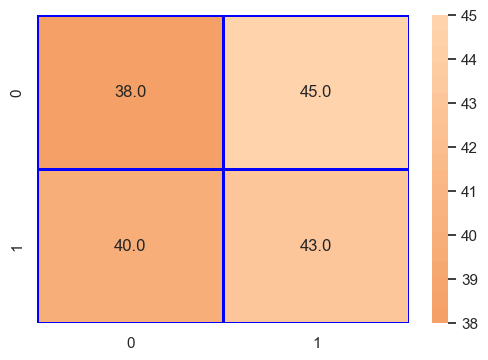

Root Mean Square Error (RMSE): 0.7156





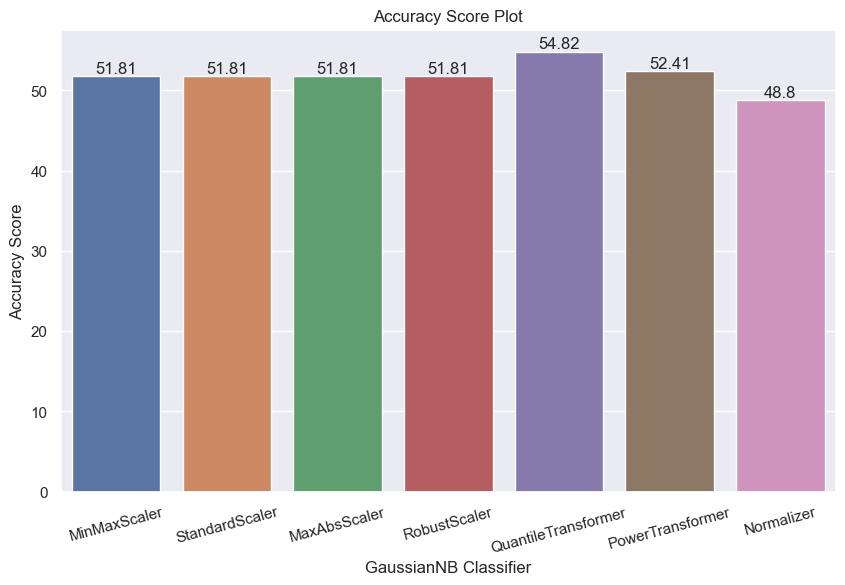

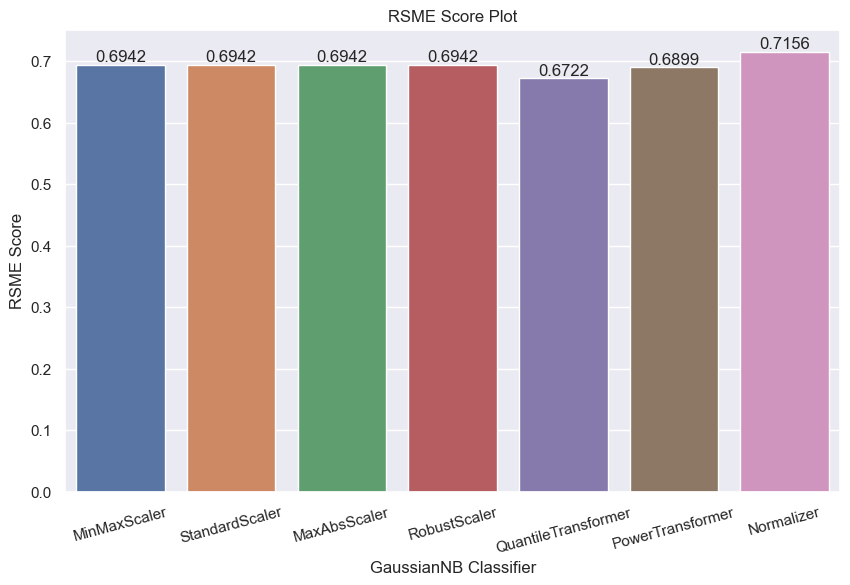




Modele name : DecisionTreeClassifier
Scaler name : MinMaxScaler
10 K-Fold Accuracy_score : [0.6061 0.6515 0.6515 0.4545 0.5909 0.6667 0.5909 0.6061 0.6818 0.6061]
10 K-Fold Average Accuracy_score : 61.06 %
Accuracy_score: 63.25 %
Loss: 36.75 %
Cohen_kappa_score: 26.51 %
Classification_report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65        83
           1       0.65      0.58      0.61        83

    accuracy                           0.63       166
   macro avg       0.63      0.63      0.63       166
weighted avg       0.63      0.63      0.63       166

confusion_matrix:
 [[57 26]
 [35 48]]


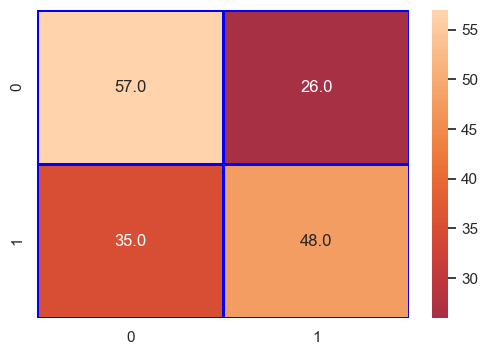

Root Mean Square Error (RMSE): 0.6062



Modele name : DecisionTreeClassifier
Scaler name : StandardScaler
10 K-Fold Accuracy_score : [0.6061 0.697  0.697  0.4242 0.5455 0.6212 0.6515 0.5303 0.6818 0.5758]
10 K-Fold Average Accuracy_score : 60.3 %
Accuracy_score: 61.45 %
Loss: 38.55 %
Cohen_kappa_score: 22.89 %
Classification_report:
               precision    recall  f1-score   support

           0       0.61      0.64      0.62        83
           1       0.62      0.59      0.60        83

    accuracy                           0.61       166
   macro avg       0.61      0.61      0.61       166
weighted avg       0.61      0.61      0.61       166

confusion_matrix:
 [[53 30]
 [34 49]]


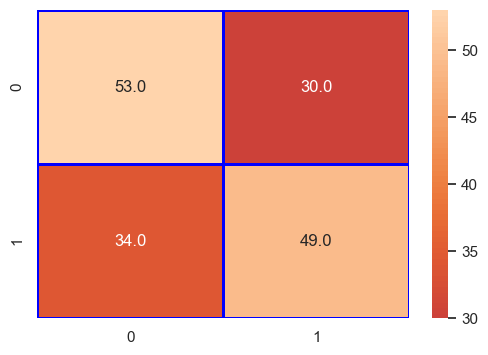

Root Mean Square Error (RMSE): 0.6209



Modele name : DecisionTreeClassifier
Scaler name : MaxAbsScaler
10 K-Fold Accuracy_score : [0.6212 0.7273 0.6515 0.4697 0.6061 0.5606 0.6515 0.5758 0.6515 0.6212]
10 K-Fold Average Accuracy_score : 61.36 %
Accuracy_score: 68.07 %
Loss: 31.93 %
Cohen_kappa_score: 36.14 %
Classification_report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68        83
           1       0.68      0.67      0.68        83

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166

confusion_matrix:
 [[57 26]
 [27 56]]


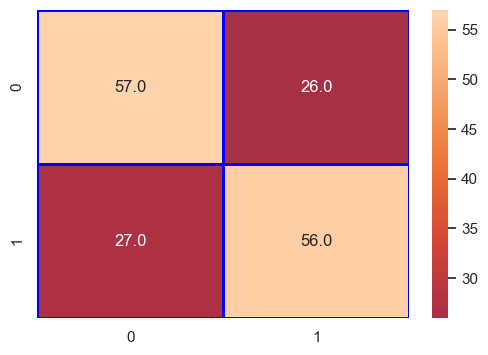

Root Mean Square Error (RMSE): 0.565



Modele name : DecisionTreeClassifier
Scaler name : RobustScaler
10 K-Fold Accuracy_score : [0.5909 0.697  0.6515 0.4545 0.6061 0.6212 0.6515 0.6212 0.697  0.5758]
10 K-Fold Average Accuracy_score : 61.67 %
Accuracy_score: 64.46 %
Loss: 35.54 %
Cohen_kappa_score: 28.92 %
Classification_report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65        83
           1       0.65      0.64      0.64        83

    accuracy                           0.64       166
   macro avg       0.64      0.64      0.64       166
weighted avg       0.64      0.64      0.64       166

confusion_matrix:
 [[54 29]
 [30 53]]


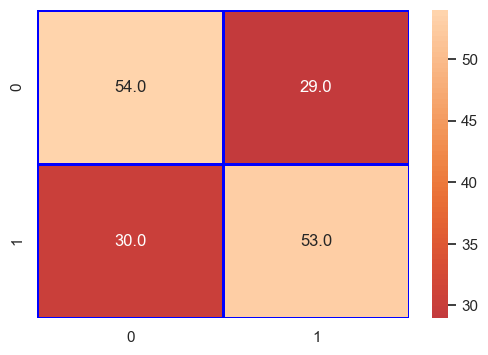

Root Mean Square Error (RMSE): 0.5962



Modele name : DecisionTreeClassifier
Scaler name : QuantileTransformer
10 K-Fold Accuracy_score : [0.6212 0.697  0.6667 0.4545 0.6212 0.6212 0.5909 0.5303 0.6212 0.6061]
10 K-Fold Average Accuracy_score : 60.3 %
Accuracy_score: 64.46 %
Loss: 35.54 %
Cohen_kappa_score: 28.92 %
Classification_report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65        83
           1       0.65      0.61      0.63        83

    accuracy                           0.64       166
   macro avg       0.65      0.64      0.64       166
weighted avg       0.65      0.64      0.64       166

confusion_matrix:
 [[56 27]
 [32 51]]


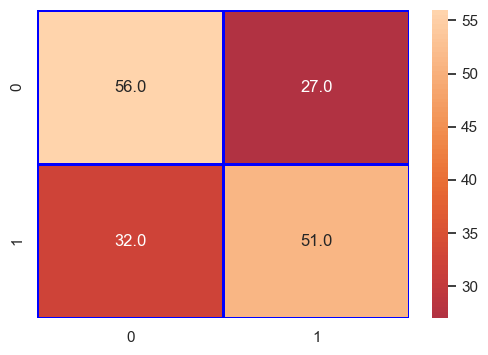

Root Mean Square Error (RMSE): 0.5962



Modele name : DecisionTreeClassifier
Scaler name : PowerTransformer
10 K-Fold Accuracy_score : [0.6515 0.6667 0.6818 0.4394 0.5909 0.5455 0.5909 0.5758 0.6212 0.5909]
10 K-Fold Average Accuracy_score : 59.55 %
Accuracy_score: 64.46 %
Loss: 35.54 %
Cohen_kappa_score: 28.92 %
Classification_report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65        83
           1       0.65      0.61      0.63        83

    accuracy                           0.64       166
   macro avg       0.65      0.64      0.64       166
weighted avg       0.65      0.64      0.64       166

confusion_matrix:
 [[56 27]
 [32 51]]


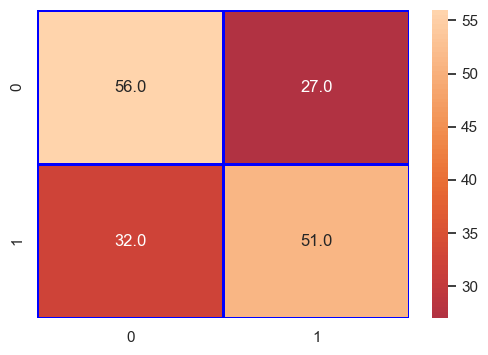

Root Mean Square Error (RMSE): 0.5962



Modele name : DecisionTreeClassifier
Scaler name : Normalizer
10 K-Fold Accuracy_score : [0.5152 0.6364 0.5909 0.697  0.5909 0.5758 0.5606 0.4697 0.5455 0.6212]
10 K-Fold Average Accuracy_score : 58.03 %
Accuracy_score: 59.04 %
Loss: 40.96 %
Cohen_kappa_score: 18.07 %
Classification_report:
               precision    recall  f1-score   support

           0       0.58      0.66      0.62        83
           1       0.61      0.52      0.56        83

    accuracy                           0.59       166
   macro avg       0.59      0.59      0.59       166
weighted avg       0.59      0.59      0.59       166

confusion_matrix:
 [[55 28]
 [40 43]]


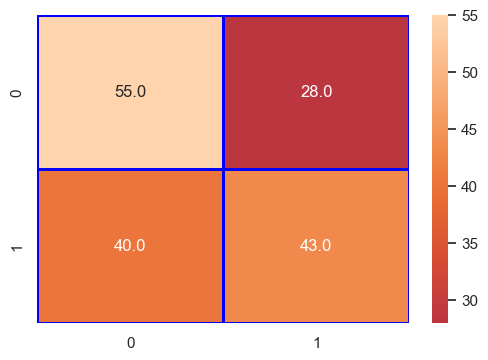

Root Mean Square Error (RMSE): 0.64





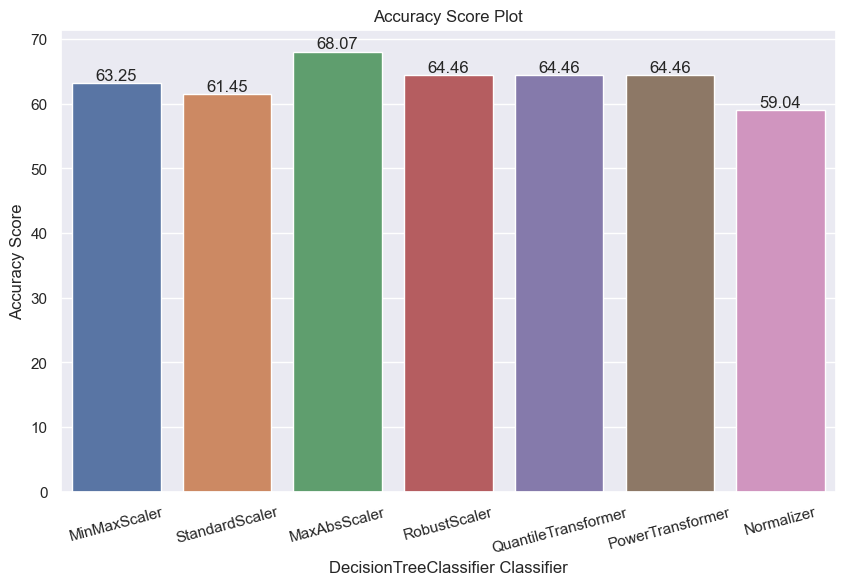

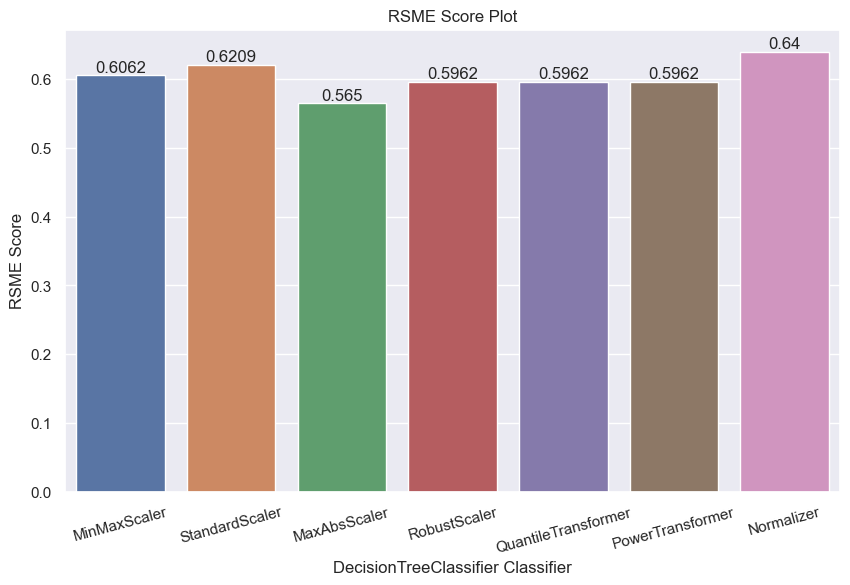




Modele name : RandomForestClassifier
Scaler name : MinMaxScaler
10 K-Fold Accuracy_score : [0.6667 0.6061 0.697  0.6667 0.7121 0.7273 0.5909 0.5758 0.803  0.697 ]
10 K-Fold Average Accuracy_score : 67.42 %
Accuracy_score: 71.08 %
Loss: 28.92 %
Cohen_kappa_score: 42.17 %
Classification_report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        83
           1       0.74      0.65      0.69        83

    accuracy                           0.71       166
   macro avg       0.71      0.71      0.71       166
weighted avg       0.71      0.71      0.71       166

confusion_matrix:
 [[64 19]
 [29 54]]


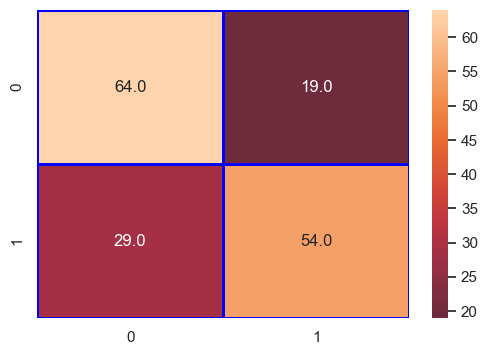

Root Mean Square Error (RMSE): 0.5377



Modele name : RandomForestClassifier
Scaler name : StandardScaler
10 K-Fold Accuracy_score : [0.6364 0.697  0.6818 0.6818 0.7121 0.6667 0.6667 0.6364 0.7424 0.6212]
10 K-Fold Average Accuracy_score : 67.42 %
Accuracy_score: 67.47 %
Loss: 32.53 %
Cohen_kappa_score: 34.94 %
Classification_report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.69        83
           1       0.69      0.64      0.66        83

    accuracy                           0.67       166
   macro avg       0.68      0.67      0.67       166
weighted avg       0.68      0.67      0.67       166

confusion_matrix:
 [[59 24]
 [30 53]]


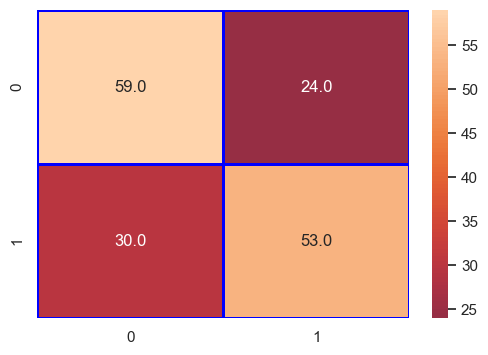

Root Mean Square Error (RMSE): 0.5704



Modele name : RandomForestClassifier
Scaler name : MaxAbsScaler
10 K-Fold Accuracy_score : [0.6364 0.6515 0.697  0.697  0.697  0.6515 0.6364 0.6061 0.697  0.5758]
10 K-Fold Average Accuracy_score : 65.45 %
Accuracy_score: 69.28 %
Loss: 30.72 %
Cohen_kappa_score: 38.55 %
Classification_report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71        83
           1       0.72      0.64      0.68        83

    accuracy                           0.69       166
   macro avg       0.70      0.69      0.69       166
weighted avg       0.70      0.69      0.69       166

confusion_matrix:
 [[62 21]
 [30 53]]


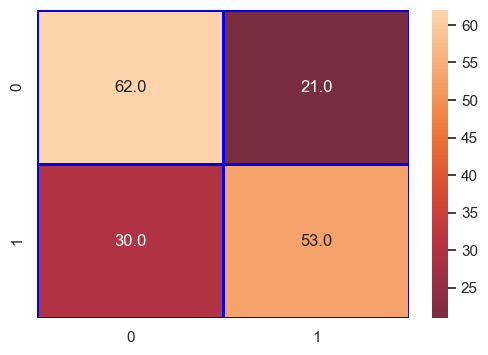

Root Mean Square Error (RMSE): 0.5543



Modele name : RandomForestClassifier
Scaler name : RobustScaler
10 K-Fold Accuracy_score : [0.6818 0.6515 0.6667 0.6515 0.7576 0.6818 0.6667 0.5758 0.7121 0.6818]
10 K-Fold Average Accuracy_score : 67.27 %
Accuracy_score: 66.87 %
Loss: 33.13 %
Cohen_kappa_score: 33.73 %
Classification_report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.69        83
           1       0.70      0.59      0.64        83

    accuracy                           0.67       166
   macro avg       0.67      0.67      0.67       166
weighted avg       0.67      0.67      0.67       166

confusion_matrix:
 [[62 21]
 [34 49]]


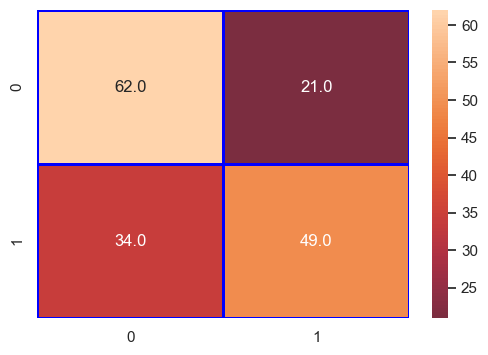

Root Mean Square Error (RMSE): 0.5756



Modele name : RandomForestClassifier
Scaler name : QuantileTransformer
10 K-Fold Accuracy_score : [0.6667 0.6364 0.7273 0.6818 0.7424 0.6515 0.6212 0.6364 0.7576 0.6364]
10 K-Fold Average Accuracy_score : 67.58 %
Accuracy_score: 67.47 %
Loss: 32.53 %
Cohen_kappa_score: 34.94 %
Classification_report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69        83
           1       0.70      0.61      0.65        83

    accuracy                           0.67       166
   macro avg       0.68      0.67      0.67       166
weighted avg       0.68      0.67      0.67       166

confusion_matrix:
 [[61 22]
 [32 51]]


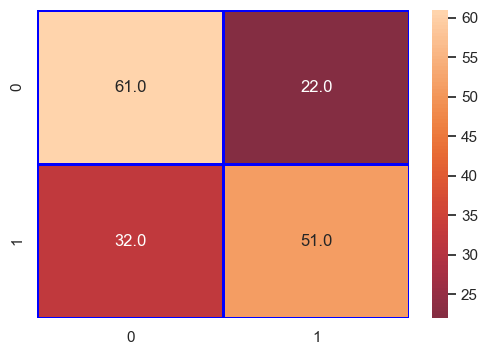

Root Mean Square Error (RMSE): 0.5704



Modele name : RandomForestClassifier
Scaler name : PowerTransformer
10 K-Fold Accuracy_score : [0.7424 0.6515 0.7121 0.6667 0.7576 0.6515 0.6818 0.6212 0.7727 0.6212]
10 K-Fold Average Accuracy_score : 68.79 %
Accuracy_score: 65.06 %
Loss: 34.94 %
Cohen_kappa_score: 30.12 %
Classification_report:
               precision    recall  f1-score   support

           0       0.64      0.69      0.66        83
           1       0.66      0.61      0.64        83

    accuracy                           0.65       166
   macro avg       0.65      0.65      0.65       166
weighted avg       0.65      0.65      0.65       166

confusion_matrix:
 [[57 26]
 [32 51]]


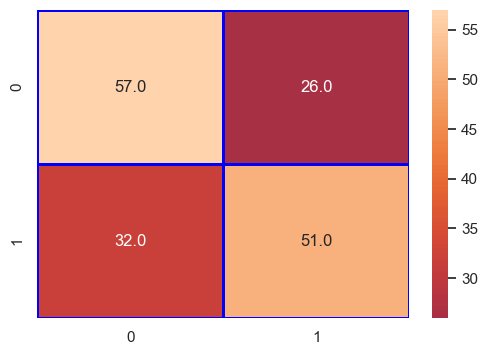

Root Mean Square Error (RMSE): 0.5911



Modele name : RandomForestClassifier
Scaler name : Normalizer
10 K-Fold Accuracy_score : [0.6515 0.5303 0.7424 0.7424 0.7727 0.6212 0.6212 0.5758 0.7121 0.6061]
10 K-Fold Average Accuracy_score : 65.76 %
Accuracy_score: 69.88 %
Loss: 30.12 %
Cohen_kappa_score: 39.76 %
Classification_report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71        83
           1       0.71      0.66      0.69        83

    accuracy                           0.70       166
   macro avg       0.70      0.70      0.70       166
weighted avg       0.70      0.70      0.70       166

confusion_matrix:
 [[61 22]
 [28 55]]


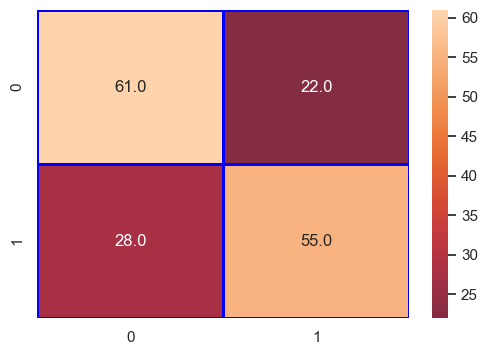

Root Mean Square Error (RMSE): 0.5488





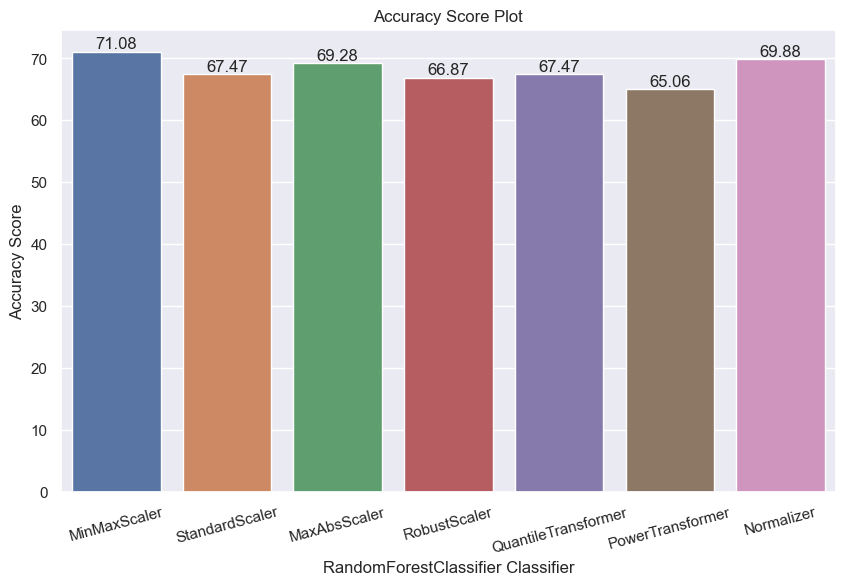

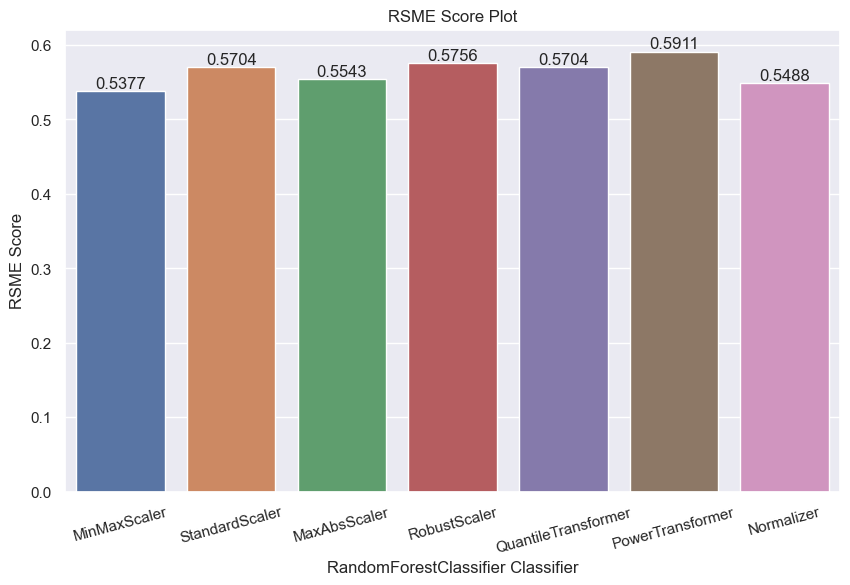




Done...


In [30]:
for model in model_list:
    for scaler in scaler_list:
        run_pipeline(X_train, X_test, y_train, y_test, scaler, model)
    
    # plot data
    plot_df = pd.DataFrame(plot_data_list, columns=['classifier', 'scaler', 'accuracy_score'])
    plot_df.to_csv(f"Dataset\\{str(type(model).__name__)}_accuracy_score_plot_data_01_LS_Disease_Prediction.csv", index=False)

    sns.set(rc={'figure.figsize':(10,6)})
    # ax = sns.barplot(data=plot_df, x="classifier", y="accuracy_score", hue="scaler")
    ax = sns.barplot(data=plot_df, x="scaler", y="accuracy_score") # , hue="scaler"
    plt.title('Accuracy Score Plot')
    plt.xlabel(str(type(model).__name__)+' Classifier')
    plt.ylabel('Accuracy Score')
    ax.tick_params(axis='x', rotation=15)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.show()


    plot_RSME = pd.DataFrame(plot_RSME_list, columns=['classifier', 'scaler', 'RSME_score'])
    plot_RSME.to_csv(f"Dataset\\{str(type(model).__name__)}_RSME_score_plot_data_01_LS_Disease_Prediction.csv", index=False)

    sns.set(rc={'figure.figsize':(10,6)})
    # ax = sns.barplot(data=plot_df, x="classifier", y="accuracy_score", hue="scaler")
    ax = sns.barplot(data=plot_RSME, x="scaler", y="RSME_score") # , hue="scaler"
    plt.title('RSME Score Plot')
    plt.xlabel(str(type(model).__name__)+' Classifier')
    plt.ylabel('RSME Score')
    ax.tick_params(axis='x', rotation=15)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.show()


    # empty list
    plot_data_list = []
    plot_RSME_list = []
    print("\n\n")

print("Done...")